In [5]:

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen

# pgmpy for probabilistic graphical models (v1.0.0 compatible)
try:
    from pgmpy.models import DiscreteBayesianNetwork
    from pgmpy.estimators import HillClimbSearch, BIC
    from pgmpy.inference import VariableElimination
except ImportError as e:
    print(f"⚠️ Failed to import pgmpy: {e}. Ensure pgmpy==1.0.0 is installed.")
    raise


plt.style.use('seaborn-v0_8')
sns.set_context("notebook", font_scale=1.2)


def check_library_versions():
    from packaging import version
    required_versions = {
        'pandas': '2.0.0',
        'networkx': '3.0.0',
        'numpy': '1.26.0',
        'matplotlib': '3.7.0',
        'seaborn': '0.12.0',
        'pgmpy': '1.0.0'
    }
    import pkg_resources
    for lib, min_version in required_versions.items():
        try:
            installed_version = pkg_resources.get_distribution(lib).version
            if version.parse(installed_version) < version.parse(min_version):
                print(f"⚠️ Warning: {lib} version {installed_version} may be outdated, recommended >= {min_version}")
            else:
                print(f"✓ {lib} version {installed_version} is compatible")
        except pkg_resources.ContextualVersionConflict as e:
            print(f"⚠️ Warning: {lib} version check failed due to dependency conflict: {e}")
        except pkg_resources.DistributionNotFound:
            print(f"⚠️ Warning: {lib} is not installed")
    print("✅ Environment setup complete.")

check_library_versions()

✓ pandas version 2.2.3 is compatible
✓ networkx version 3.5 is compatible
✓ numpy version 1.26.4 is compatible
✓ matplotlib version 3.7.2 is compatible
✓ seaborn version 0.12.2 is compatible
⚠️ Warning: pgmpy version check failed due to dependency conflict: (nvidia-nvjitlink-cu12 12.5.82 (/usr/local/lib/python3.11/dist-packages), Requirement.parse('nvidia-nvjitlink-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64"'), {'torch'})
✅ Environment setup complete.


In [6]:
import pandas as pd
from urllib.error import URLError

# Define column names for the Cleveland heart disease dataset
col_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# URL for the processed Cleveland dataset
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

def load_heart_disease_data(url, columns):
    try:
        df = pd.read_csv(url, header=None, names=columns, na_values='?', encoding='utf-8')
        print("✅ Dataset loaded successfully.")
        print(f"Dataset shape: {df.shape[0]} records, {df.shape[1]} features")
        return df
    except URLError as e:
        print(f"⚠️ Failed to load data from {url}: {e}")
        raise
    except pd.errors.ParserError as e:
        print(f"⚠️ Error parsing CSV file: {e}")
        raise

data = load_heart_disease_data(data_url, col_names)
display(data.head()) 

✅ Dataset loaded successfully.
Dataset shape: 303 records, 14 features


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


None


Dataset Shape: (303, 14)

--- Missing Value Analysis ---
Missing values per column:


ca      4
thal    2
dtype: int64


--- Target Variable Distribution ---


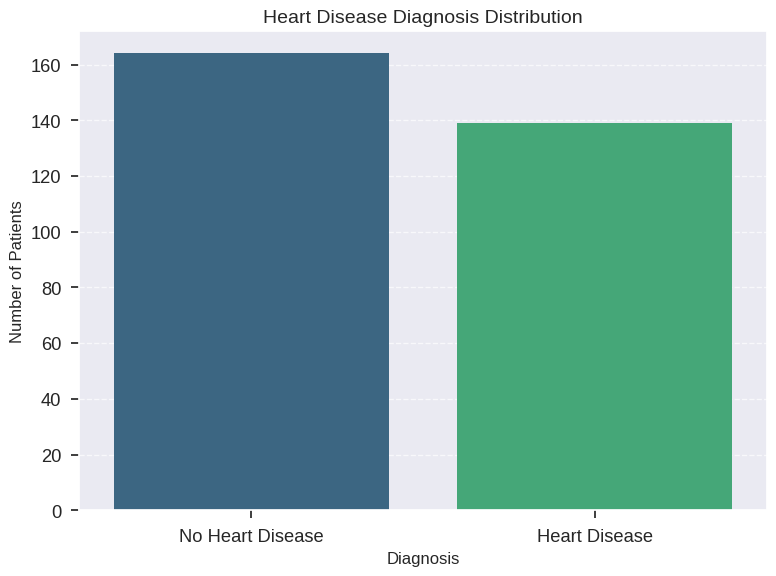


--- Age Distribution ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


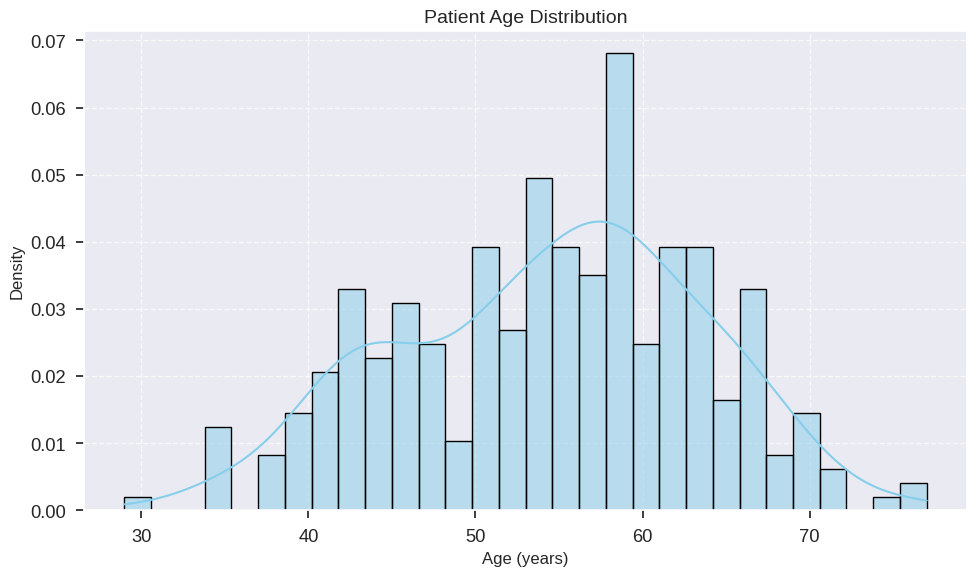

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Perform exploratory data analysis
def perform_eda(df):
    # Data Overview
    print("--- Data Overview ---")
    display(df.info())  # Better rendering in notebooks
    print("\nDataset Shape:", df.shape)

    # Missing Value Analysis
    print("\n--- Missing Value Analysis ---")
    missing_values = df.isnull().sum()
    print("Missing values per column:")
    display(missing_values[missing_values > 0])  # Show only columns with missing values

    # Target Variable Distribution
    print("\n--- Target Variable Distribution ---")
    target_counts = df['target'].apply(lambda x: 'Heart Disease' if x > 0 else 'No Heart Disease').value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')
    plt.title('Heart Disease Diagnosis Distribution', fontsize=14)
    plt.xlabel('Diagnosis', fontsize=12)
    plt.ylabel('Number of Patients', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Age Distribution
    print("\n--- Age Distribution ---")
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df['age'], kde=True, bins=30, color='skyblue', stat='density')
    plt.title('Patient Age Distribution', fontsize=14)
    plt.xlabel('Age (years)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Execute EDA
perform_eda(data)

In [11]:
import pandas as pd
import numpy as np

# Preprocessing and feature engineering function
def preprocess_data(df_input):
    
    df = df_input.copy()

    # Impute missing values with mode for specified columns
    for col in ['ca', 'thal']:
        if df[col].isnull().any():
            mode_value = df[col].mode()[0]
            df[col] = df[col].fillna(mode_value)
            print(f"Imputed missing values in '{col}' with mode: {mode_value}")

    # Discretize continuous features
    discretize_configs = {
        'age': {
            'bins': [0, 40, 55, 65, 100],
            'labels': ['Young', 'Middle-Aged', 'Senior', 'Very-Senior'],
            'right': True
        },
        'trestbps': {
            'bins': [0, 120, 140, 220],
            'labels': ['Normal', 'High', 'Very-High'],
            'right': True
        },
        'chol': {
            'bins': [0, 200, 240, 600],
            'labels': ['Normal', 'Borderline', 'High'],
            'right': True
        },
        'thalach': {
            'bins': [0, 140, 170, 250],
            'labels': ['Low', 'Medium', 'High'],
            'right': True
        }
    }
    for col, config in discretize_configs.items():
        try:
            df[col] = pd.cut(df[col], bins=config['bins'], labels=config['labels'], 
                            right=config['right'], include_lowest=True)
        except ValueError as e:
            print(f"⚠️ Error discretizing '{col}': {e}")
            raise

    # Map numeric codes to descriptive categories
    mapping_configs = {
        'target': lambda x: 'Heart-Disease' if x > 0 else 'No-Heart-Disease',
        'sex': {1.0: 'Male', 0.0: 'Female'},
        'cp': {1.0: 'Typical-Angina', 2.0: 'Atypical-Angina', 3.0: 'Non-Anginal-Pain', 4.0: 'Asymptomatic'},
        'fbs': {1.0: 'True', 0.0: 'False'},
        'restecg': {0.0: 'Normal', 1.0: 'ST-T-Abnormality', 2.0: 'LV-Hypertrophy'},
        'exang': {1.0: 'Yes', 0.0: 'No'},
        'slope': {1.0: 'Upsloping', 2.0: 'Flat', 3.0: 'Downsloping'},
        'thal': {3.0: 'Normal', 6.0: 'Fixed-Defect', 7.0: 'Reversable-Defect'}
    }
    for col, mapping in mapping_configs.items():
        try:
            df[col] = df[col].map(mapping) if callable(mapping) else df[col].replace(mapping)
            if df[col].isnull().any():
                print(f"⚠️ Warning: Mapping for '{col}' introduced missing values")
        except Exception as e:
            print(f"⚠️ Error mapping '{col}': {e}")
            raise

    df['ca'] = df['ca'].astype(str).replace({'0.0': '0', '1.0': '1', '2.0': '2', '3.0': '3'})

    print("\n--- Data Types after Preprocessing ---")
    display(df.dtypes)

    print("✅ Preprocessing and Feature Engineering complete.")
    print("\n--- Data after Preprocessing ---")
    display(df.head())  
    return df


df_processed = preprocess_data(data)

Imputed missing values in 'ca' with mode: 0.0
Imputed missing values in 'thal' with mode: 3.0

--- Data Types after Preprocessing ---


age         category
sex           object
cp            object
trestbps    category
chol        category
fbs           object
restecg       object
thalach     category
exang         object
oldpeak      float64
slope         object
ca            object
thal          object
target        object
dtype: object

✅ Preprocessing and Feature Engineering complete.

--- Data after Preprocessing ---


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,Senior,Male,Typical-Angina,Very-High,Borderline,True,LV-Hypertrophy,Medium,No,2.3,Downsloping,0,Fixed-Defect,No-Heart-Disease
1,Very-Senior,Male,Asymptomatic,Very-High,High,False,LV-Hypertrophy,Low,Yes,1.5,Flat,3,Normal,Heart-Disease
2,Very-Senior,Male,Asymptomatic,Normal,Borderline,False,LV-Hypertrophy,Low,Yes,2.6,Flat,2,Reversable-Defect,Heart-Disease
3,Young,Male,Non-Anginal-Pain,High,High,False,Normal,High,No,3.5,Downsloping,0,Normal,No-Heart-Disease
4,Middle-Aged,Female,Atypical-Angina,High,Borderline,False,LV-Hypertrophy,High,No,1.4,Upsloping,0,Normal,No-Heart-Disease


  0%|          | 0/100 [00:00<?, ?it/s]

✅ Bayesian Network learning complete. Model valid: True

--- Learned Network Edges ---
age -> trestbps
cp -> exang
target -> ca
target -> cp
target -> slope
target -> thalach
thal -> sex
thal -> target
thalach -> age

--- Bayesian Network Visualization ---


/tmp/ipykernel_36/448769070.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


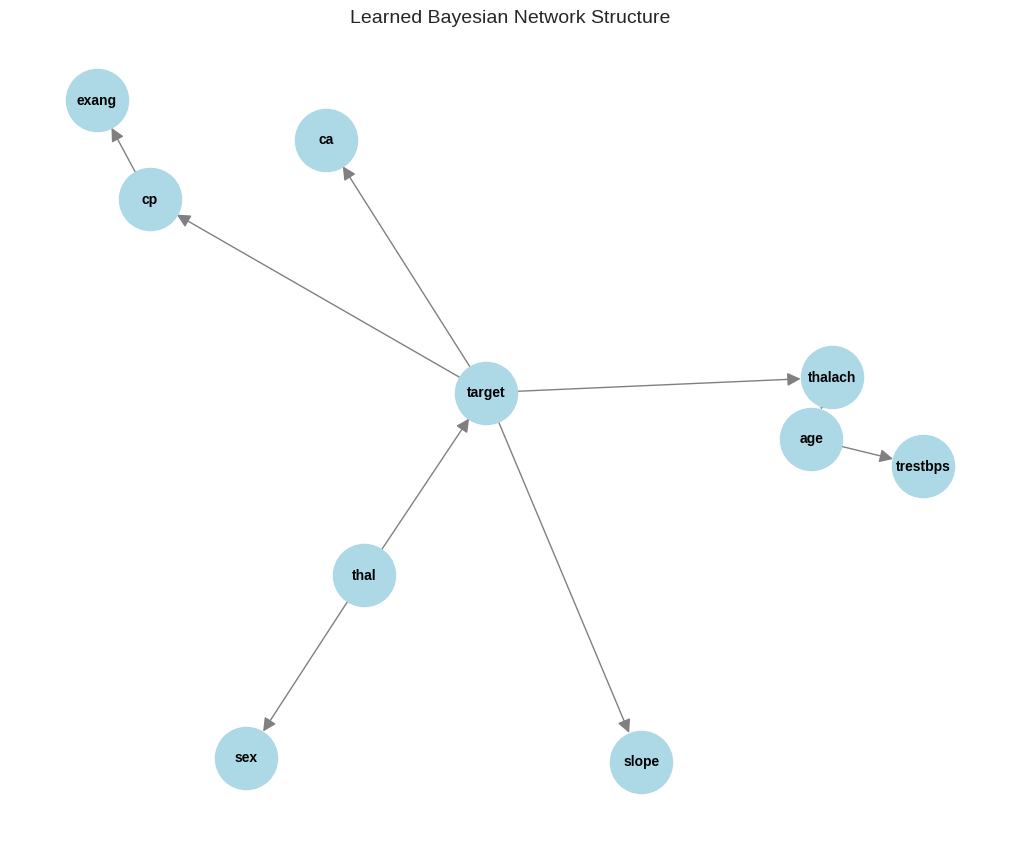

In [13]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BIC, MaximumLikelihoodEstimator
import networkx as nx
import matplotlib.pyplot as plt

# Learn Bayesian Network structure and parameters
def learn_bayesian_network(df):
    try:
        model = DiscreteBayesianNetwork()

        hc_estimator = HillClimbSearch(df)
        best_model = hc_estimator.estimate(
            scoring_method=BIC(df),
            max_iter=100,  
            max_indegree=4  
        )

        if not best_model.edges():
            print("⚠️ Warning: No edges learned. Model may be underconstrained.")
        model.add_edges_from(best_model.edges())
        model.fit(data=df, estimator=MaximumLikelihoodEstimator)  

        is_valid = model.check_model()
        print(f"✅ Bayesian Network learning complete. Model valid: {is_valid}")

        print("\n--- Learned Network Edges ---")
        if model.edges():
            for edge in sorted(model.edges()):  
                print(f"{edge[0]} -> {edge[1]}")
        else:
            print("No edges in the model.")

        print("\n--- Bayesian Network Visualization ---")
        plt.figure(figsize=(10, 8))
        G = nx.DiGraph(model.edges())
        pos = nx.spring_layout(G, seed=42)  
        nx.draw(
            G, pos, with_labels=True, node_color='lightblue', 
            node_size=2000, font_size=10, font_weight='bold', 
            arrowsize=20, edge_color='gray'
        )
        plt.title("Learned Bayesian Network Structure", fontsize=14)
        plt.tight_layout()
        plt.show()

        return model
    except Exception as e:
        print(f"⚠️ Error learning Bayesian Network: {e}")
        raise

model = learn_bayesian_network(df_processed)

✅ Network visualization saved to /kaggle/working/figures/bayesian_network_20250710_194454.png


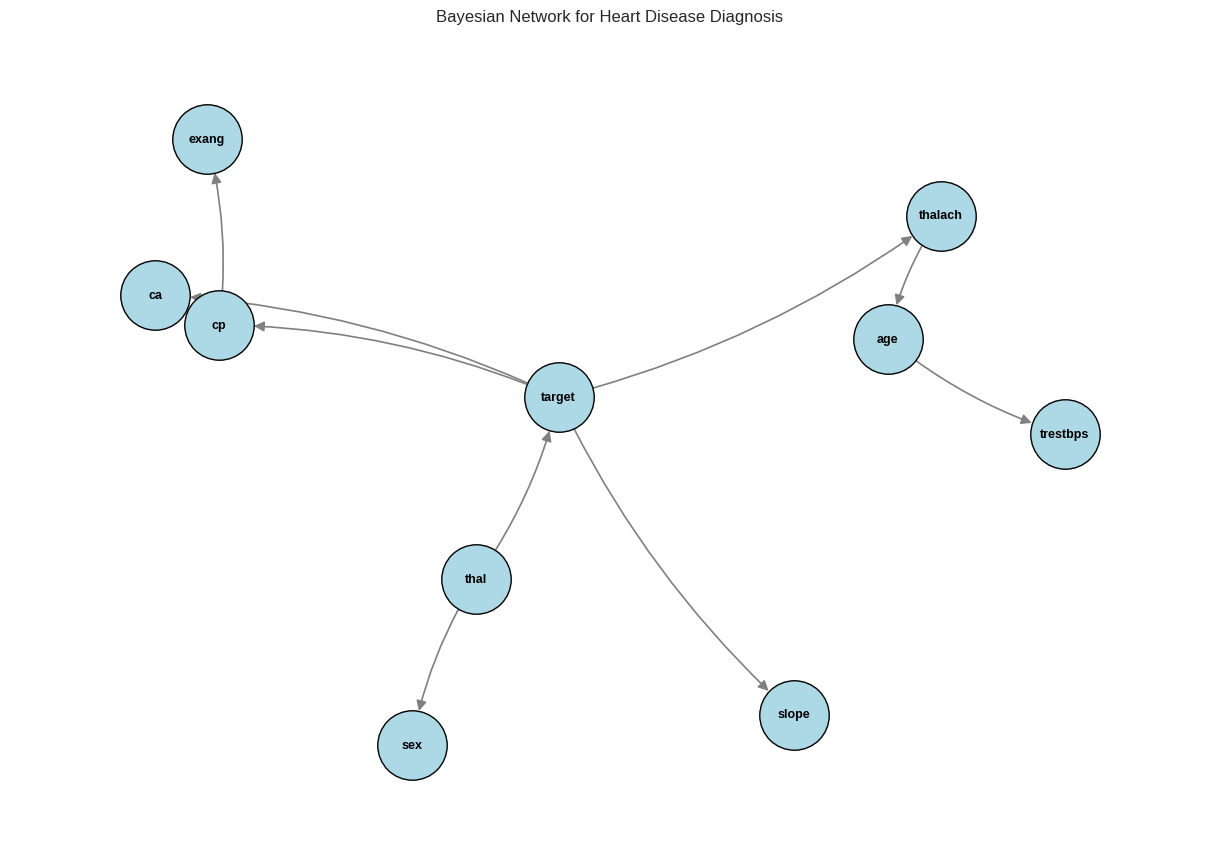

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Visualize Bayesian Network
def visualize_bayesian_network(model, output_path="/kaggle/working/figures"):
    try:
        
        nx_model = nx.DiGraph()
        nx_model.add_nodes_from(model.nodes())
        nx_model.add_edges_from(model.edges())

        
        if not nx_model.nodes():
            print("⚠️ Warning: No nodes in the network. Visualization skipped.")
            return

        
        plt.figure(figsize=(12, 8))  
        pos = nx.spring_layout(nx_model, seed=42, k=0.6)  
        nx.draw(
            nx_model,
            pos,
            with_labels=True,
            node_size=2500, 
            node_color='lightblue',
            font_size=9,
            font_weight='bold',
            arrowsize=15,
            width=1.2,
            edge_color='gray',
            edgecolors='black',  
            connectionstyle='arc3,rad=0.1' 
        )
        plt.title("Bayesian Network for Heart Disease Diagnosis", fontsize=12, pad=15)
        plt.margins(0.1)  

        
        if output_path:
            
            os.makedirs(output_path, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = os.path.join(output_path, f"bayesian_network_{timestamp}.png")
            plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
            print(f"✅ Network visualization saved to {filename}")

        plt.show()
    except Exception as e:
        print(f"⚠️ Error visualizing Bayesian Network: {e}")
        raise


visualize_bayesian_network(model, output_path="/kaggle/working/figures")

In [17]:
from pgmpy.inference import VariableElimination

# Initialize inference engine
def setup_inference(model):
    try:
        if not model.check_model():
            raise ValueError("Invalid model: Missing or inconsistent CPDs.")

        inference = VariableElimination(model)
        print("✅ Inference engine initialized successfully.")

        print(f"\nModel Summary:")
        print(f"Nodes: {sorted(model.nodes())}")
        print(f"Number of CPDs: {len(model.get_cpds())}")

        return inference
    except AttributeError as e:
        print(f"⚠️ Error: Invalid model object. Ensure 'model' is a valid DiscreteBayesianNetwork. Details: {e}")
        raise
    except ValueError as e:
        print(f"⚠️ Error: {e}")
        raise
    except Exception as e:
        print(f"⚠️ Unexpected error during inference setup: {e}")
        raise

inference = setup_inference(model)

✅ Inference engine initialized successfully.

Model Summary:
Nodes: ['age', 'ca', 'cp', 'exang', 'sex', 'slope', 'target', 'thal', 'thalach', 'trestbps']
Number of CPDs: 10


In [18]:
from pgmpy.inference import VariableElimination
import pandas as pd

# Perform probabilistic queries
def run_probabilistic_queries(inference, model):
    try:
        if not isinstance(inference, VariableElimination):
            raise ValueError("Inference engine not initialized.")

        def format_prob(prob, variable):
            return {state: f"{prob.values[i]:.2%}" for i, state in enumerate(prob.state_names[variable])}

        print("\n--- Scenario 1: Middle-Aged Male with High Cholesterol ---")
        try:
            query1 = inference.query(
                variables=['target'],
                evidence={'sex': 'Male', 'age': 'Middle-Aged', 'chol': 'High'},
                joint=False
            )
            print("Probability of heart disease:", format_prob(query1['target'], 'target'))
            print("Interpretation: Higher cholesterol in middle-aged males increases heart disease risk.")
        except ValueError as e:
            print(f"⚠️ Scenario 1 Error: Invalid evidence or model configuration. Details: {e}")

        
        print("\n--- Scenario 2: Senior Female with Asymptomatic Chest Pain ---")
        try:
            query2 = inference.query(
                variables=['target'],
                evidence={'sex': 'Female', 'age': 'Senior', 'cp': 'Asymptomatic', 'trestbps': 'Normal'},
                joint=False
            )
            print("Probability of heart disease:", format_prob(query2['target'], 'target'))
            print("Interpretation: Asymptomatic chest pain in senior females suggests elevated risk, despite normal blood pressure.")
        except ValueError as e:
            print(f"⚠️ Scenario 2 Error: Invalid evidence or model configuration. Details: {e}")

        
        print("\n--- Scenario 3: Most Likely Chest Pain Type ---")
        try:
            query3 = inference.map_query(
                variables=['cp'],
                evidence={'target': 'Heart-Disease'},  
                show_progress=False
            )
            print(f"Most likely chest pain type: {query3['cp']}")
            print("Interpretation: Asymptomatic chest pain is a key indicator for heart disease.")
        except ValueError as e:
            print(f"⚠️ Scenario 3 Error: Invalid evidence or model configuration. Details: {e}")

        
        print("\n--- Scenario 4: Belief Updating with Exercise-Induced Angina ---")
        try:
            prob_a = inference.query(variables=['target'], evidence={'cp': 'Typical-Angina'}, joint=False)
            prob_disease_a = prob_a['target'].get_value(target='Heart-Disease')
            prob_b = inference.query(variables=['target'], evidence={'cp': 'Typical-Angina', 'exang': 'Yes'}, joint=False)
            prob_disease_b = prob_b['target'].get_value(target='Heart-Disease')
            print(f"Probability of Heart Disease (Typical Angina only): {prob_disease_a:.2%}")
            print(f"Probability of Heart Disease (Typical Angina + Exercise Angina): {prob_disease_b:.2%}")
            print("Interpretation: Exercise-induced angina significantly increases heart disease probability.")
        except ValueError as e:
            print(f"⚠️ Scenario 4 Error: Invalid evidence or model configuration. Details: {e}")

        
        print("\n--- Model State Names ---")
        for node in sorted(model.nodes()):
            cpd = model.get_cpds(node)
            if cpd:
                print(f"{node}: {cpd.state_names[node]}")

    except Exception as e:
        print(f"⚠️ Unexpected error in queries: {e}")
        raise


run_probabilistic_queries(inference, model)


--- Scenario 1: Middle-Aged Male with High Cholesterol ---
⚠️ Scenario 1 Error: Invalid evidence or model configuration. Details: Node chol not in graph

--- Scenario 2: Senior Female with Asymptomatic Chest Pain ---
Probability of heart disease: {'Heart-Disease': '62.84%', 'No-Heart-Disease': '37.16%'}
Interpretation: Asymptomatic chest pain in senior females suggests elevated risk, despite normal blood pressure.

--- Scenario 3: Most Likely Chest Pain Type ---
Most likely chest pain type: Asymptomatic
Interpretation: Asymptomatic chest pain is a key indicator for heart disease.

--- Scenario 4: Belief Updating with Exercise-Induced Angina ---
Probability of Heart Disease (Typical Angina only): 30.43%
Probability of Heart Disease (Typical Angina + Exercise Angina): 30.43%
Interpretation: Exercise-induced angina significantly increases heart disease probability.

--- Model State Names ---
age: ['Middle-Aged', 'Senior', 'Very-Senior', 'Young']
ca: ['0', '1', '2', '3']
cp: ['Asymptomati